## 8.1. Simulation time series

This notebook produces the simulations that we will use in script 8.2 to test our pseudotime method.

In [44]:
### import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
np.random.seed(1)
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

### Simulation

Here we simulate a single cell dataset for a couple of genes. The gene's expression changes over time according to the function explained bellow. We then assign each cell a (hidden) time and sample their gene expression from this function.

In [45]:
# meta parameters
k_monotonic = 10 # number of genes with monotonic dynamics
k_complex = 10 # number of genes with complex dynamics
n_cells = 1000 
noise = 0.05

# sample parameters for simulation of monotonic genes
neg_monotonic = np.random.randint(2, size=k_monotonic) # this parameters determines whether the genes go up or down
a_monotonic = np.random.uniform(5,15, k_monotonic)  # offset 
b_monotonic = np.random.uniform(0,8, k_monotonic)  # width of the sigmoid function

# sample parameters for simulation of complex genes
neg = np.random.randint(2, size=k_complex) # this parameters determines whether the genes go up + down or down + up
t_switch = np.random.uniform(5, 10, k_complex)  # switching time point from up to down (or vice-versa)
a = np.random.uniform(0, 8, k_complex)  # offset - determines wether we start with 0 (or max) or in between value
b = np.random.uniform(1,3, k_complex)  # width of the sigmoid function

In [46]:
def sigmoid(x, a, b): # sigmoid function with parameters a = center; b = width
        return 1/(1+np.exp(-(x-a)/b))
    
def sigmoid_switch(x, a, b, t_switch):
        return sigmoid(x, a,b) - sigmoid(x-t_switch, a,b)

def simulate_monotonic_genes(time):
    # this function recovers each gene's values for the provided timepoints
    vals = []
    for i in range(k_monotonic):
        f = sigmoid(time, a_monotonic[i], b_monotonic[i])
        vals.append(1-f if neg_monotonic[i] else f)
    return np.array(vals).T

def simulate_complex_genes(time):
    # this function recovers each gene's values for the provided timepoints
    vals = []
    for i in range(k_complex):
        f = sigmoid_switch(time, a[i], b[i], t_switch[i])
        vals.append(1-f if neg[i] else f)
    return np.array(vals).T

def noise_and_scale(X, noise=0.05): # function to min_max scale and add gaussian noise
    # min_max_scale
    X-=np.min(X, axis=0)
    X/=np.max(X, axis=0)
    # add noise
    X+=np.random.normal(0, noise, X.shape)
    # rescale + get rid of negative values
    X/=np.max(X, axis=0)
    X[X<0]=0
    return X

### Let´s start!

First we explore the genes that will be used for the simulation in a visualization.

We have two different gene categories:
1. __monotonic genes__: those are genes that go only up or down over time. This is simulated by a single sigmoid function with varying center and width 
2. __complex genes__: those are genes that go up and down or down and up (non monotonic. This is simulated by two symmetrical sigmoid functions whose start is separated by t_switch time

In [47]:
### generate genes
time = np.linspace(0,20,n_cells)

monotonic_genes = simulate_monotonic_genes(time)
complex_genes = simulate_complex_genes(time)

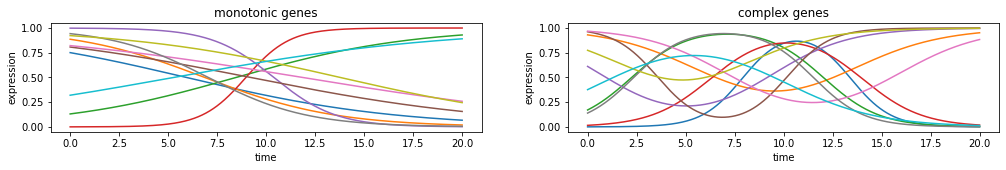

In [48]:
### visualize all monotonic and all complex genes together
fig, ax = plt.subplots(1,2,figsize=(17,2))

for idx, gene in enumerate(monotonic_genes[0]):
    ax[0].plot(time, monotonic_genes[:,idx])
    ax[0].set_xlabel("time")
    ax[0].set_ylabel("expression")
    
for idx, gene in enumerate(complex_genes[0]):
    ax[1].plot(time, complex_genes[:,idx])
    ax[1].set_xlabel("time")
    ax[1].set_ylabel("expression")
    
# add titles
ax[0].title.set_text("monotonic genes")
ax[1].title.set_text("complex genes")

# save figure
save_path = "../figures/8.1.monotonic_and_complex genes.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

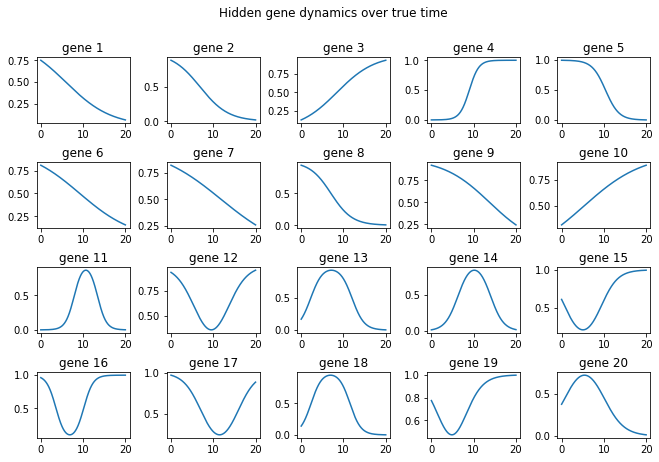

In [49]:
### plot hidden gene dynamics (one plot per gene)
fig, ax = plt.subplots(4,5,figsize=(11,7), gridspec_kw={'wspace':0.4, 'hspace':0.6})

ax = ax.ravel()

for idx,_ in enumerate(monotonic_genes[0]):
    ax[idx].plot(time, monotonic_genes[:,idx])
    ax[idx].title.set_text(f"gene {idx+1}")
    
for idx,_ in enumerate(complex_genes[0]):
    ax[idx+len(monotonic_genes[0])].plot(time, complex_genes[:,idx])
    ax[idx+len(monotonic_genes[0])].title.set_text(f"gene {idx+11}")
    
fig.suptitle('Hidden gene dynamics over true time')

# save figure
save_path = "../figures/8.1.all_genes_hidden_dynamics.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()

#### (A) Simulation with continuous time

Here each cell has a real continuous time used for fitting

In [50]:
# simulate
monotonic_X = noise_and_scale(simulate_monotonic_genes(time), noise)
complex_X = noise_and_scale(simulate_complex_genes(time), noise)

X=np.concatenate((monotonic_X, complex_X), axis=1)

data_path = "../results/simulations/"

np.savetxt(data_path + "X_continuous_time.csv", X, delimiter=",",fmt='%1.3f')
np.savetxt(data_path + "t_continuous_time.csv", time, delimiter=",",fmt='%1.1f')

#### (B) Simulation with discrete time

Here we sample cells at a continuous time points $t$. To represent the asynchronous progression of cells through time, the true time of the cell is then assigned to $t+\mathcal{N}(0, 1.5)$

In [51]:
# simulate time 
assigned_time = []
for i in [0, 5, 10, 20]:
    assigned_time.extend(np.repeat(i, int(n_cells/4)))
assigned_time = np.array(assigned_time)    
time = assigned_time + np.random.normal(0, 1.5, n_cells)

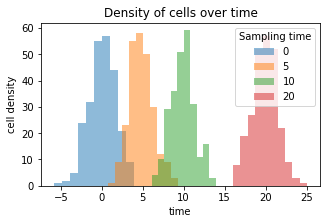

In [52]:
### visualize cell density
fig, ax = plt.subplots(1,1,figsize=(5,3))

for i in np.unique(assigned_time):
    ax.hist(time[assigned_time==i], alpha=0.5, label=i)
ax.set_title("Density of cells over time")
ax.legend(title="Sampling time", loc='upper right')
ax.set_xlabel("time")
ax.set_ylabel("cell density")

# save figure
save_path = "../figures/8.1.density_cells_time_series.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()

In [53]:
# simulate data
monotonic_X = noise_and_scale(simulate_monotonic_genes(time), noise)
complex_X = noise_and_scale(simulate_complex_genes(time), noise)

X=np.concatenate((monotonic_X, complex_X), axis=1)
out_time = np.array([assigned_time, time]).T

data_path = "../results/simulations/"
np.savetxt(data_path+"X_discrete_time.csv", X, delimiter=",",fmt='%1.3f')
np.savetxt(data_path+"t_discrete_time.csv", out_time, delimiter=",",fmt='%1.1f')

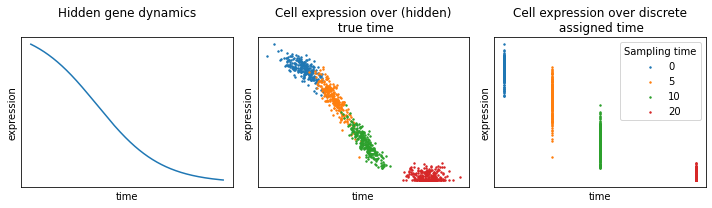

In [54]:
# let's have a look at one gene in the time series simulation

# hidden dynamics
t = np.linspace(0,20,n_cells)
monotonic_X = noise_and_scale(simulate_monotonic_genes(t), 0)
complex_X = noise_and_scale(simulate_complex_genes(t), 0)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

idx = 1 # gene idx
axs[0].plot(t, monotonic_X[:,idx])
for i in np.unique(assigned_time):
    axs[1].scatter(time[assigned_time==i], X[:,idx][assigned_time==i], s=2)
    axs[2].scatter(assigned_time[assigned_time==i], X[:,idx][assigned_time==i], s=2,label=i)
    
axs[0].set_title("Hidden gene dynamics\n")
axs[1].set_title("Cell expression over (hidden)\n true time")
axs[2].set_title("Cell expression over discrete\n assigned time")
    
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("time")
    ax.set_ylabel("expression")

plt.legend(title="Sampling time", loc='upper right')
plt.tight_layout()

# save figure
save_path = "../figures/8.1.example_gene_time_series_sim.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()

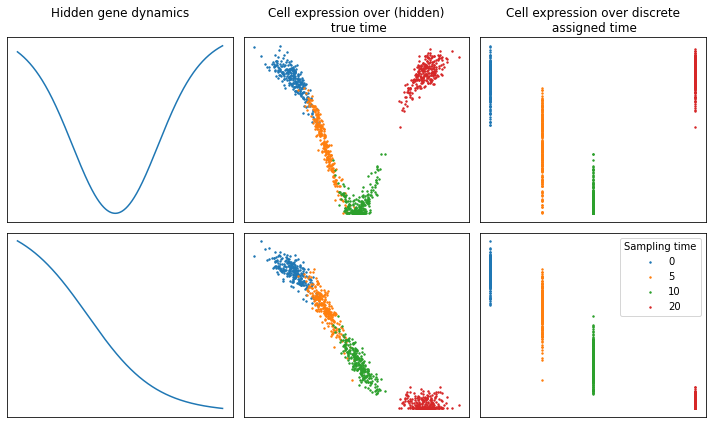

In [55]:
# let's have a look at 2 genes

# hidden dynamics
t = np.linspace(0,20,n_cells)
monotonic_X = noise_and_scale(simulate_monotonic_genes(t), 0)
complex_X = noise_and_scale(simulate_complex_genes(t), 0)

f, axs = plt.subplots(2, 3, figsize=(10, 6))

idx = 11 # complex gene idx
axs[0,0].plot(t, complex_X[:,idx-10])
for i in np.unique(assigned_time):
    axs[0,1].scatter(time[assigned_time==i], X[:,idx][assigned_time==i], s=2)
    axs[0,2].scatter(assigned_time[assigned_time==i], X[:,idx][assigned_time==i], s=2)
axs[0,0].set_title("Hidden gene dynamics\n")
axs[0,1].set_title("Cell expression over (hidden)\n true time")
axs[0,2].set_title("Cell expression over discrete\n assigned time")

idx = 1 # simple gene idx
axs[1,0].plot(t, monotonic_X[:,idx])
for i in np.unique(assigned_time):
    axs[1,1].scatter(time[assigned_time==i], X[:,idx][assigned_time==i], s=2)
    axs[1,2].scatter(assigned_time[assigned_time==i], X[:,idx][assigned_time==i], s=2,
                     label=i)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.legend(title="Sampling time", loc='upper right')
plt.tight_layout()
plt.show()

#### (C) Simulation with discrete time, non-monotonic genes only

Here we have the same simulation as in B, with the only difference that here all 20 genes are non-monotonic.

In [56]:
# meta parameters
k_monotonic = 0 # number of genes with monotonic dynamics
k_complex = 20 # number of genes with complex dynamics
n_cells = 1000 
noise = 0.05

# sample parameters for simulation of complex genes
neg = np.random.randint(2, size=k_complex) # this parameters determines whether the genes go up + down or down + up
t_switch = np.random.uniform(5, 15, k_complex)  # switching time point from up to down (or vice-versa)
a = np.random.uniform(0, 5, k_complex)  # offset - determines wether we start with 0 (or max) or in between value
b = np.random.uniform(1,8, k_complex)  # width of the sigmoid function

In [57]:
# simulate time 
assigned_time = []
for i in [0, 5, 10, 20]:
    assigned_time.extend(np.repeat(i, int(n_cells/4)))
assigned_time = np.array(assigned_time)    
time = assigned_time + np.random.normal(0, 1.5, n_cells)

In [58]:
# simulate data
complex_X = noise_and_scale(simulate_complex_genes(time), noise)

X=complex_X
out_time = np.array([assigned_time, time]).T

data_path = "../results/simulations/"
np.savetxt(data_path+"X_non_monotonic.csv", X, delimiter=",",fmt='%1.3f')
np.savetxt(data_path+"t_non_monotonic.csv", out_time, delimiter=",",fmt='%1.1f')

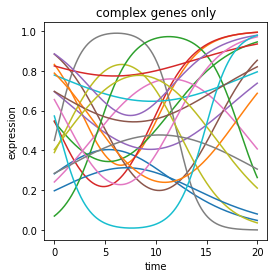

In [59]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

# hidden dynamics
time = np.linspace(0,20,n_cells)
complex_genes = simulate_complex_genes(time)

for idx, gene in enumerate(complex_genes[0]):
    ax.plot(time, complex_genes[:,idx])
    ax.set_xlabel("time")
    ax.set_ylabel("expression")
    
# add titles
ax.title.set_text("complex genes only")

# save figure
save_path = "../figures/8.1.genes_simulation_complex_only.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)